In [4]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

In [5]:
sns.set_context("notebook")
sns.set_style("dark")

In [6]:
use_example = False
if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    old_raw_data = {"data": []}
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            with open(f"data/{file}", "r") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < 1000:
                    continue
                old_raw_data["data"] += [{**el, "match_ts": match_ts} for el in match_data["data"]]

In [7]:
len(old_raw_data["data"])

173683

## Loading raw data from analytics system

In [8]:
raw_data = []

for el in old_raw_data["data"]:
    # Value
    if "value" in el:
        el["value"] = float(el["value"])

    # Unique ts of match
    if "i" in el:
        el["i"] = el["i"] + "-" + el["match_ts"]
    if "t" in el:
        el["t"] = el["t"] + "-" + el["match_ts"]
    if "ips" in el:
        el["ips"] = el["ips"] + "-" + el["match_ts"]
    if "tps" in el:
        el["tps"] = el["tps"] + "-" + el["match_ts"]

    # Classes
    if "il" in el and "if" in el:
        el["i-faction-class"] = el["if"] + "-" + el["il"]
    if "tl" in el and "tf" in el:
        el["t-faction-class"] = el["tf"] + "-" + el["tl"]

    # Instigator coords
    if "ic" in el:
        el["ic_x"] = float(el["ic"].split(" ")[0].split("=")[1])
    if "ic" in el:
        el["ic_y"] = float(el["ic"].split(" ")[1].split("=")[1])

    # Target coords
    if "tc" in el:
        el["tc_x"] = float(el["tc"].split(" ")[0].split("=")[1])
    if "tc" in el:
        el["tc_y"] = float(el["tc"].split(" ")[1].split("=")[1])

    raw_data.append(el)

## Analyzing damage (per pawn, per class)

In [9]:
damage_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Damage"])
# Removing friendly fire when analyzing damage
damage_df = damage_df[damage_df["if"] != damage_df["tf"]]

In [10]:
damage_df.head()

,value,i,t,ips,tps,il,tl,if,tf,ic,tc,Type,match_ts,i-faction-class,t-faction-class,ic_x,ic_y,tc_x,tc_y
0,15.000000,CH_2147298354-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147451513-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,MelS,MelS,LSM,CSM,X=4756.736 Y=-11375.842 Z=-338.260,X=6564.843 Y=-13317.048 Z=287.102,Damage,2023-09-05T14-21-47.813736,LSM-MelS,CSM-MelS,4756.736,-11375.842,6564.843,-13317.048
1,15.000000,CH_2147298354-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147451513-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,MelS,MelS,LSM,CSM,X=4761.684 Y=-11146.692 Z=-361.951,X=6216.694 Y=-13053.242 Z=232.571,Damage,2023-09-05T14-21-47.813736,LSM-MelS,CSM-MelS,4761.684,-11146.692,6216.694,-13053.242
2,15.000000,CH_2147298354-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147451513-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,MelS,MelS,LSM,CSM,X=4618.393 Y=-10947.164 Z=-392.781,X=5943.171 Y=-12736.564 Z=107.742,Damage,2023-09-05T14-21-47.813736,LSM-MelS,CSM-MelS,4618.393,-10947.164,5943.171,-12736.564
3,20.742249,CH_2147298354-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147451513-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,MelS,MelS,LSM,CSM,X=4611.332 Y=-10937.122 Z=-394.447,X=5636.104 Y=-11770.576 Z=-218.947,Damage,2023-09-05T14-21-47.813736,LSM-MelS,CSM-MelS,4611.332,-10937.122,5636.104,-11770.576
4,30.000000,CH_2147298023-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147480996-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,TacS,MelS,LSM,CSM,X=4294.929 Y=-11244.208 Z=-363.980,X=5578.625 Y=-11682.660 Z=-242.010,Damage,2023-09-05T14-21-47.813736,LSM-TacS,CSM-MelS,4294.929,-11244.208,5578.625,-11682.660


In [11]:
# damage_df["value"] = pd.to_numeric(damage_df["value"])
damage_per_pawn = damage_df.groupby(["i"]).agg(
    damage_per_life=('value', 'sum'),
    loadout=('i-faction-class', 'first')
)
damage_per_pawn.head()

,damage_per_life,loadout
i,,
CH_2145795998-2023-09-09T19-47-40.033082,195.000000,LSM-SupS
CH_2145797202-2023-09-09T19-47-40.033082,183.429123,LSM-TacS
CH_2145797577-2023-09-09T19-47-40.033082,110.000000,CSM-HboS
CH_2145800736-2023-09-09T19-47-40.033082,460.000000,CSM-MelV
CH_2145802590-2023-09-09T19-47-40.033082,635.000000,LSM-MelS


In [12]:
damage_per_life_for_classes = damage_per_pawn.sort_values(by='loadout').groupby("loadout").agg(
    mean_damage_per_life=('damage_per_life', 'mean'),
    std_damage_per_life=('damage_per_life', 'std')
)
damage_per_life_for_classes

,mean_damage_per_life,std_damage_per_life
loadout,,
CSM-AucV,1030.647543,867.554606
CSM-HboS,905.925382,972.764520
CSM-JpaS,416.436791,459.798974
CSM-JpaVA,880.657578,944.159725
CSM-MelS,406.328966,419.335447
CSM-MelV,641.745942,654.582020
CSM-PcaS,868.001108,1016.547442
CSM-SupS,411.237992,505.922825
CSM-TacS,519.779874,609.157137


In [10]:
# On subplots
# fig, axes = plt.subplots(2, 2)
# Returns the future plotted figure and the subplot grid
# They can be used in at least two ways :
#     axes[i, j].plot(data)
#     .boxplot(by = "data", ax=axes[i, j])

# Getting sub dataframes (those can be chained)
# damage_per_pawn[damage_per_pawn["loadout"] == "CSM-AucV"]
# damage_per_pawn[damage_per_pawn["loadout"].isin(["CSM-AucV", "LSM-AucV"])]
# damage_per_pawn[damage_per_pawn["loadout"].str.startswith("CSM")]
# damage_per_pawn[damage_per_pawn["loadout"].str.contains("S")]
# To get what doesn't satisfy the condition, add a ~
# damage_per_pawn[~damage_per_pawn["loadout"] == "CSM-AucV"]

In [13]:
factions = [
    "LSM", 
    "CSM"
]
classes = [
    "Auc",
    "Hbo",
    "Jpa",
    "Mel",
    "Pca",
    "Sup",
    "Tac"
]

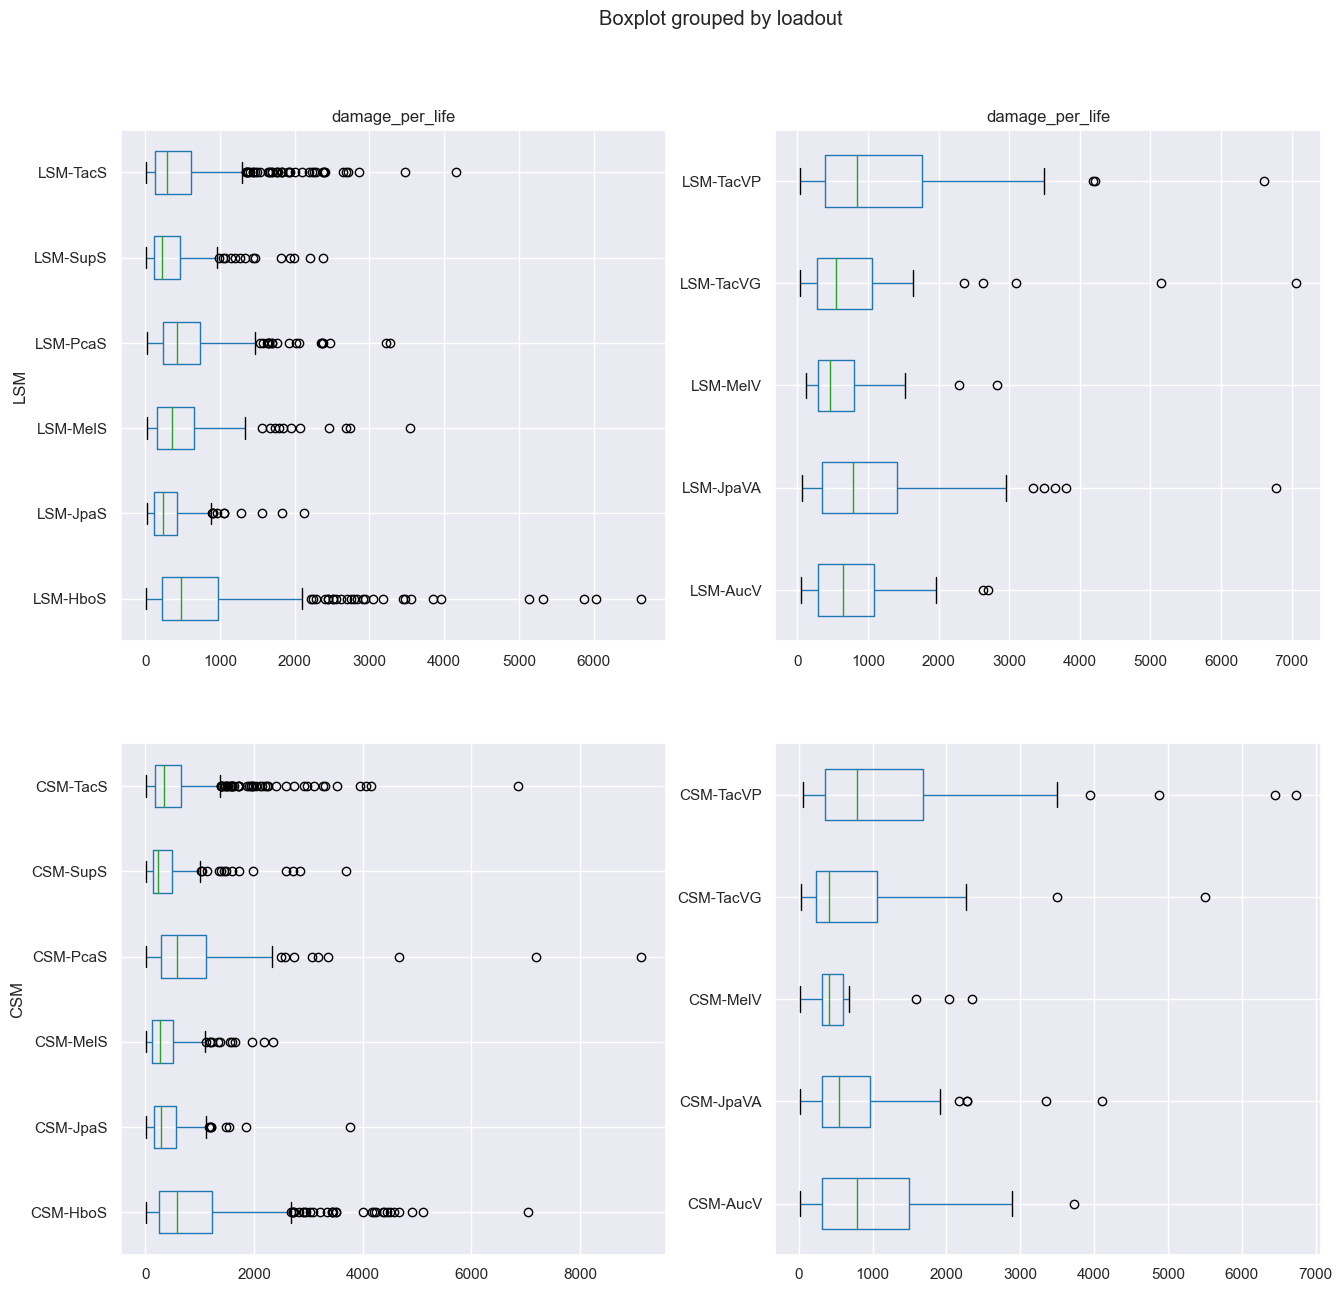

In [14]:
fig, axes = plt.subplots(len(factions), 2, figsize=(15, 15))
base = damage_per_pawn

for i in range (0, len(factions)):
    # Get faction
    standard = base[base["loadout"].str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard["loadout"].str.contains(classes[j]+"V")]
        veteran = veteran[~veteran["loadout"].str.contains(classes[j]+"S")]
    standard.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[i,0])
    veteran.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[i,1])

    # Sort titles and labels
    if (i != 0):
        axes[i,0].set_title("")
        axes[i,1].set_title("")
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")
    
# axs[1, 1].boxplot(damage_per_pawn, vert=False)
# damage_per_pawn.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[1,1])
# sns.violinplot(damage_per_pawn, x="damage_per_life", y="loadout")

## Analyzing XP (per pawn, per class and action)

In [15]:
xp_df = pd.DataFrame([el for el in raw_data if el["Type"] == "XP"])
xp_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,tc_x,tc_y
0,CH_2147298023-2023-09-05T14-21-47.813736,-15.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4138.131 Y=-11216.999 Z=-355.835,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4138.131,-11216.999
1,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4376.996 Y=-11282.090 Z=-354.907,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4376.996,-11282.090
2,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4614.307 Y=-11435.213 Z=-337.219,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4614.307,-11435.213
3,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4614.654 Y=-11436.802 Z=-337.044,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4614.654,-11436.802
4,CH_2147298354-2023-09-05T14-21-47.813736,50.0,PS_2147451513-2023-09-05T14-21-47.813736,LSM,MelS,X=4923.494 Y=-11255.877 Z=-338.951,Assist,XP,2023-09-05T14-21-47.813736,LSM-MelS,4923.494,-11255.877


In [16]:
xp_per_pawn_and_action = xp_df.groupby(["t", "action"]).agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first')
)
xp_per_pawn_and_action.head()

xp_per_life   loadout
t                                        action                               
CH_2145796526-2023-09-09T19-47-40.033082 Assist                 50.0  CSM-TacS
CH_2145800736-2023-09-09T19-47-40.033082 Assist                 50.0  CSM-MelV
                                         Enemy down            100.0  CSM-MelV
                                         Enemy finished         50.0  CSM-MelV
CH_2145802590-2023-09-09T19-47-40.033082 Assist                 50.0  LSM-MelS

In [21]:
xp_per_pawn = xp_df.groupby("t").agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first')
)
xp_per_pawn.head()

,xp_per_life,loadout
t,,
CH_2145796526-2023-09-09T19-47-40.033082,50.0,CSM-TacS
CH_2145800736-2023-09-09T19-47-40.033082,200.0,CSM-MelV
CH_2145802590-2023-09-09T19-47-40.033082,900.0,LSM-MelS
CH_2145802992-2023-09-09T19-47-40.033082,950.0,LSM-SupS
CH_2145803389-2023-09-09T19-47-40.033082,800.0,LSM-MelS


In [22]:
xp_per_life_for_class_and_action = xp_per_pawn_and_action.groupby(["loadout", "action"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class_and_action.head()

mean_xp_per_life  std_xp_per_life
loadout  action                                            
CSM-AucV Ally down             -500.000000              NaN
         Ally revived           150.000000         0.000000
         Assist                  95.833333        50.897738
         Capture stopped        628.571429       453.557368
         Elite down             288.888889       145.296631

In [23]:
xp_per_life_for_class = xp_per_pawn.groupby(["loadout"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class

,mean_xp_per_life,std_xp_per_life
loadout,,
CSM-AucV,578.054054,872.582946
CSM-HboS,473.769892,684.757468
CSM-JpaS,507.607477,598.023581
CSM-JpaVA,889.125000,1117.809429
CSM-MelS,518.046875,621.702715
CSM-MelV,786.736842,878.349515
CSM-PcaS,227.611399,525.248512
CSM-SupS,392.195980,569.717533
CSM-TacS,513.081566,753.156241


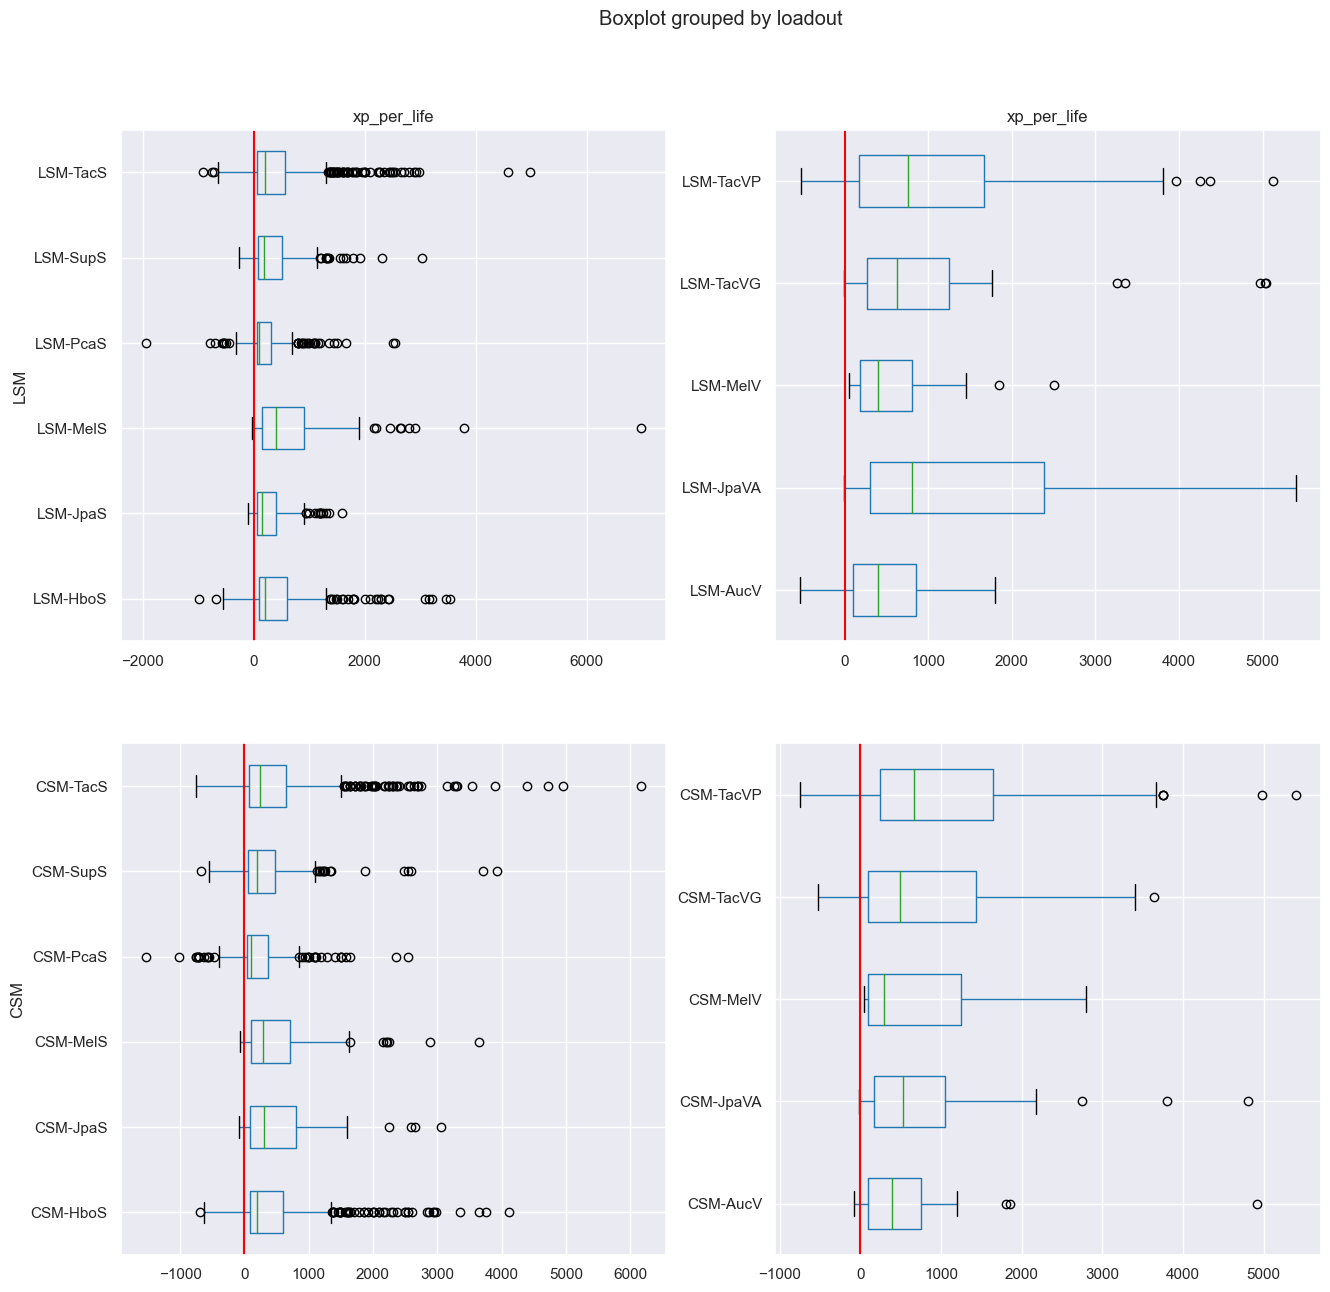

In [25]:
fig, axes = plt.subplots(len(factions), 2, figsize=(15, 15))
base = xp_per_pawn

for i in range (0, len(factions)):
    # Get faction
    standard = base[base["loadout"].str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard["loadout"].str.contains(classes[j]+"V")]
        veteran = veteran[~veteran["loadout"].str.contains(classes[j]+"S")]
    standard.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[i,0])
    veteran.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[i,1])

    # Sort titles and labels
    if (i != 0):
        axes[i,0].set_title("")
        axes[i,1].set_title("")
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")
    axes[i,0].axvline(x=0, color='red')
    axes[i,1].axvline(x=0, color='red')

# xp_per_pawn.sort_values(by='loadout').boxplot(by='loadout', vert=False)

# plt.axvline(x=0, color='red')
# plt.show()

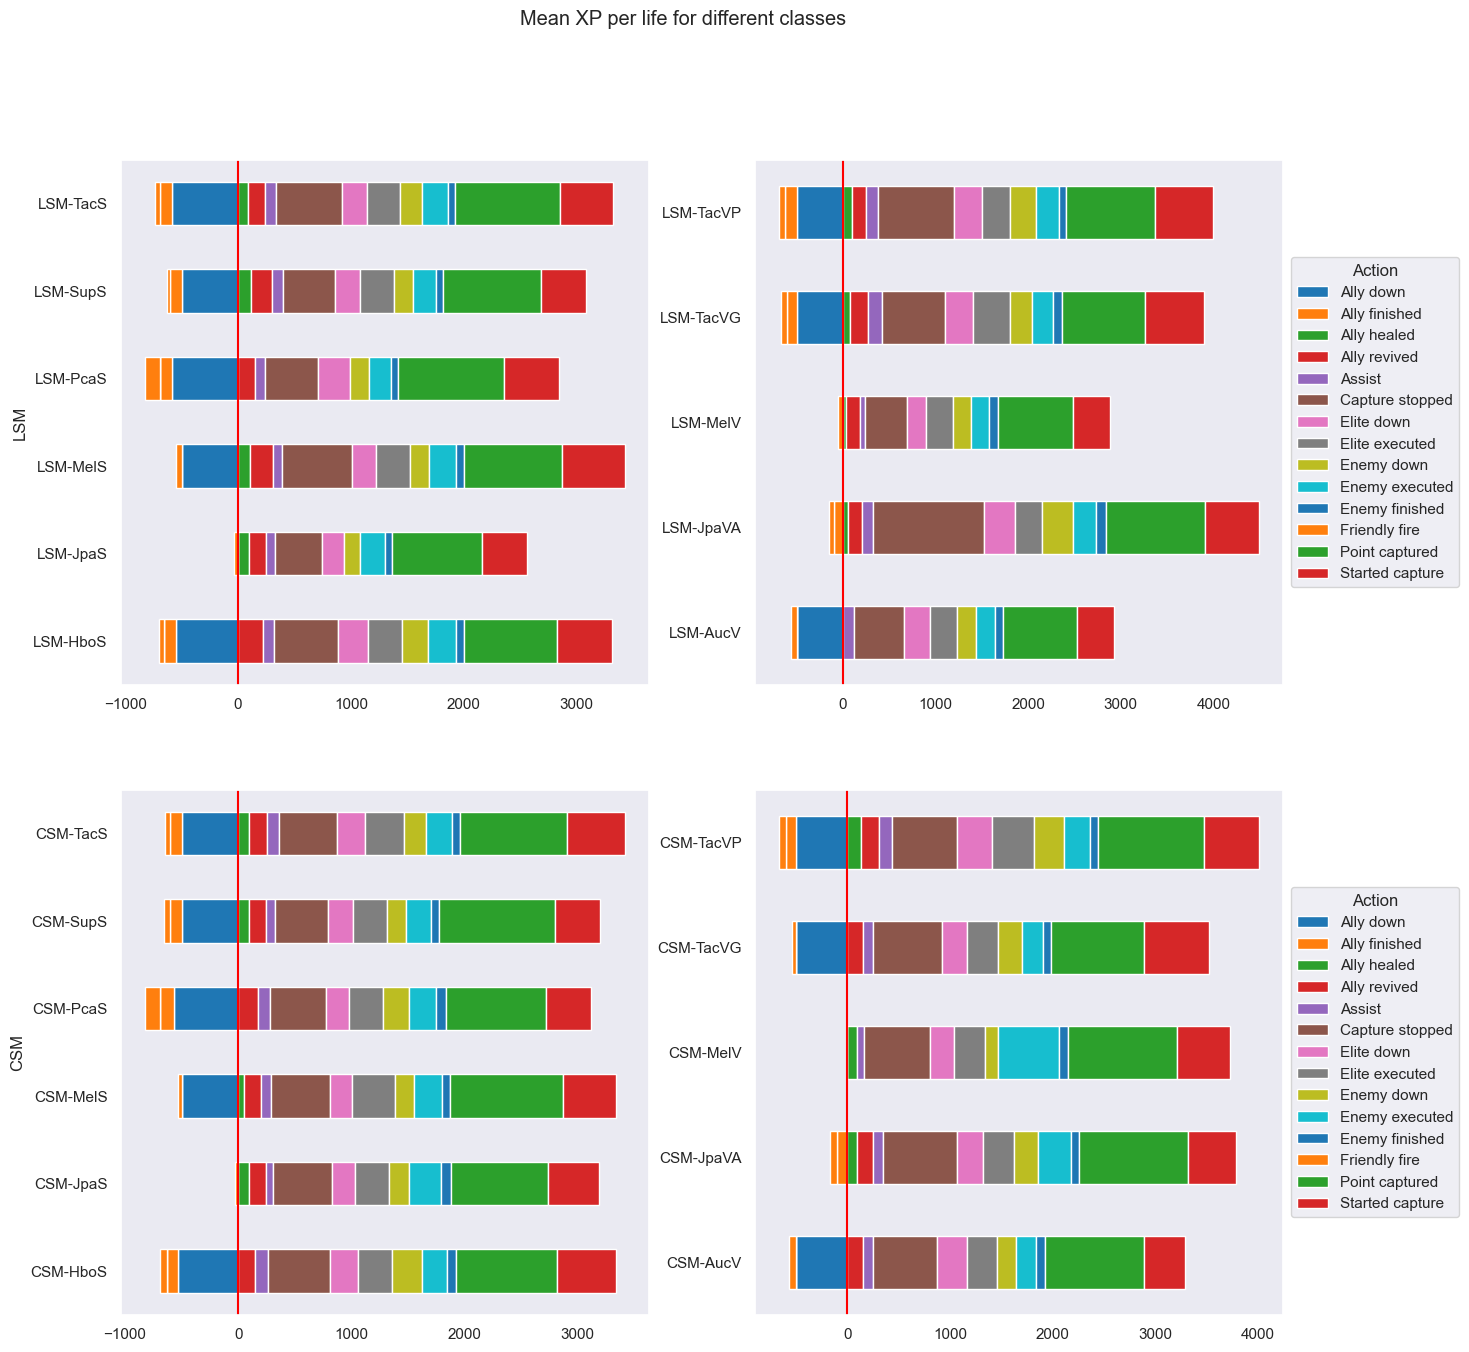

In [26]:
# Create a pivot table to reshape the data for plotting
pivot_xp_per_life_for_class_and_action = xp_per_life_for_class_and_action.reset_index()
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.pivot(index='loadout', columns='action',
                                                                                      values='mean_xp_per_life')

# Define a custom color palette
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ffbb78',  # Light Orange
    '#98df8a',  # Light Green
    '#ffaec0',  # Light Pink
    '#c5b0d5',  # Light Purple
    '#1b9e77',  # Dark Green
]

fig, axes = plt.subplots(len(factions), 2, figsize=(15, 15))
fig.suptitle("Mean XP per life for different classes")
base = pivot_xp_per_life_for_class_and_action

for i in range (0, len(factions)):
    # Get faction
    standard = base[base.index.str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard.index.str.contains(classes[j]+"V")]
        veteran = veteran[~veteran.index.str.contains(classes[j]+"S")]
    standard.plot(kind='barh', ax=axes[i,0], stacked=True, style=custom_colors)
    veteran.plot(kind='barh', ax=axes[i,1], stacked=True, style=custom_colors)

    # Sort titles and labels and stuff
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")
    axes[i,0].axvline(x=0, color='red')
    axes[i,1].axvline(x=0, color='red')
    axes[i,0].get_legend().remove()
    axes[i,1].legend(title='Action', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a rotated stacked barplot with the custom color palette
# ax = pivot_xp_per_life_for_class_and_action.plot(kind='barh', stacked=True, figsize=(20, 12), color=custom_colors)

# Customize the plot
# plt.title('Mean XP per life for different classes')
# plt.xlabel('Mean XP per life')
# plt.ylabel('Loadout')
# plt.legend(title='Action')

# plt.axvline(x=0, color='red')

# Show the plot
# plt.show()

## Analyzing KD ratios

In [27]:
kills_df = xp_df[xp_df["action"] == "Enemy down"]
kills_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,tc_x,tc_y
5,CH_2147298023-2023-09-05T14-21-47.813736,100.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=5075.189 Y=-11603.107 Z=-239.720,Enemy down,XP,2023-09-05T14-21-47.813736,LSM-TacS,5075.189,-11603.107
7,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=4580.340 Y=-6189.420 Z=574.910,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,4580.340,-6189.420
11,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=4736.840 Y=-3964.140 Z=561.360,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,4736.840,-3964.140
16,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=3769.990 Y=-4582.180 Z=555.990,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,3769.990,-4582.180
18,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=3640.960 Y=-3521.410 Z=559.720,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,3640.960,-3521.410


In [28]:
kills_per_pawn = kills_df.groupby(["t"]).agg(
    kill_count=('t', 'count'),
    loadout=('t-faction-class', 'first')
)
kills_per_pawn.head()

,kill_count,loadout
t,,
CH_2145800736-2023-09-09T19-47-40.033082,1,CSM-MelV
CH_2145802992-2023-09-09T19-47-40.033082,1,LSM-SupS
CH_2145803813-2023-09-09T19-47-40.033082,1,LSM-HboS
CH_2145805677-2023-09-09T19-47-40.033082,2,CSM-JpaS
CH_2145806625-2023-09-09T19-47-40.033082,1,CSM-TacVG


In [29]:
kills_per_life_for_classes = kills_per_pawn.groupby("loadout").agg(
    mean_kills_per_life=('kill_count', 'mean'),
    std_kills_per_life=('kill_count', 'std')
)
kills_per_life_for_classes

,mean_kills_per_life,std_kills_per_life
loadout,,
CSM-AucV,1.807692,1.296741
CSM-HboS,2.616487,2.403508
CSM-JpaS,1.750000,1.234710
CSM-JpaVA,2.333333,1.782266
CSM-MelS,1.704918,1.145197
CSM-MelV,1.250000,0.707107
CSM-PcaS,2.321429,1.987412
CSM-SupS,1.684932,1.383200
CSM-TacS,1.933754,1.584746


In [30]:
# kills_per_pawn.sort_values(by='loadout').boxplot(by="loadout", vert=False, bootstrap=1000)
# sns.violinplot(kills_per_pawn, x="kill_count", y="loadout")

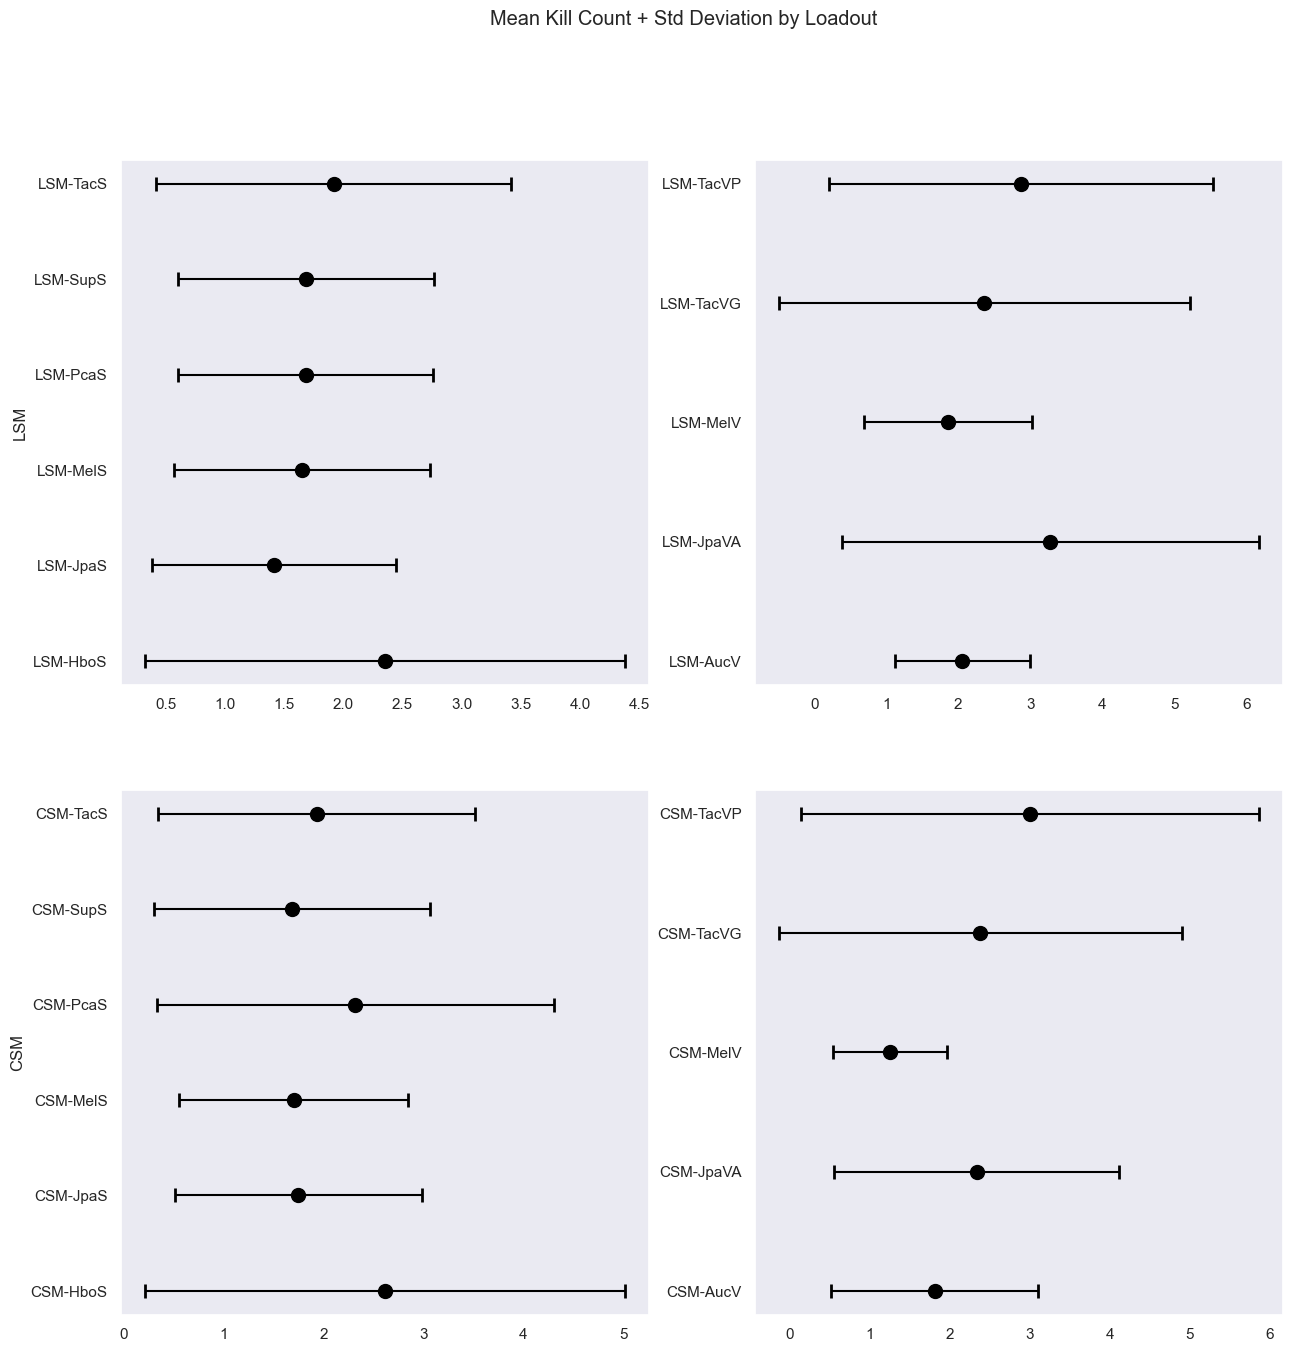

In [31]:
fig, axes = plt.subplots(len(factions), 2, figsize=(15, 15))
fig.suptitle("Mean Kill Count + Std Deviation by Loadout")
base = kills_per_pawn

for i in range (0, len(factions)):
    # Get faction
    standard = base[base["loadout"].str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard["loadout"].str.contains(classes[j]+"V")]
        veteran = veteran[~veteran["loadout"].str.contains(classes[j]+"S")]
    grouped = standard.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()
    axes[i,0].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
    for j, (mean_val, std_val) in enumerate(zip(means, stds)):
        axes[i,0].errorbar(mean_val, j, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

    grouped = veteran.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()
    axes[i,1].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
    for j, (mean_val, std_val) in enumerate(zip(means, stds)):
        axes[i,1].errorbar(mean_val, j, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')


    # Sort titles and labels
    if (i != 0):
        axes[i,0].set_title("")
        axes[i,1].set_title("")
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")

In [32]:
# Calculate mean and standard deviation
# grouped = kills_per_pawn.groupby('loadout')['kill_count']
# means = grouped.mean()
# stds = grouped.std()

# Create a horizontal scatter plot for means
# plt.scatter(means, means.index, color='black', label='Mean', s=100, marker='o')  # Adjust the 's' parameter for size

# Create vertical bars for standard deviation
# for i, (mean_val, std_val) in enumerate(zip(means, stds)):
#    plt.errorbar(mean_val, i, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

# Set labels and title
# plt.xlabel('Value')
# plt.ylabel('Loadout')
# plt.title('Mean Kill count ± Std Deviation by Loadout')

# plt.show()

## Analyzing class frequencies

In [33]:
spawn_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Spawn"])

In [34]:
class_spawns = spawn_df["t-faction-class"].value_counts()

In [35]:
class_spawns.index

Index(['CSM-TacS', 'LSM-TacS', 'CSM-HboS', 'LSM-HboS', 'CSM-SupS', 'LSM-SupS',
       'LSM-PcaS', 'LSM-MelS', 'LSM-JpaS', 'CSM-PcaS', 'CSM-MelS', 'CSM-JpaS',
       'LSM-TacVP', 'CSM-TacVP', 'LSM-JpaVA', 'CSM-AucV', 'LSM-AucV',
       'CSM-TacVG', 'LSM-TacVG', 'CSM-JpaVA', 'LSM-MelV', 'CSM-MelV'],
      dtype='object', name='t-faction-class')

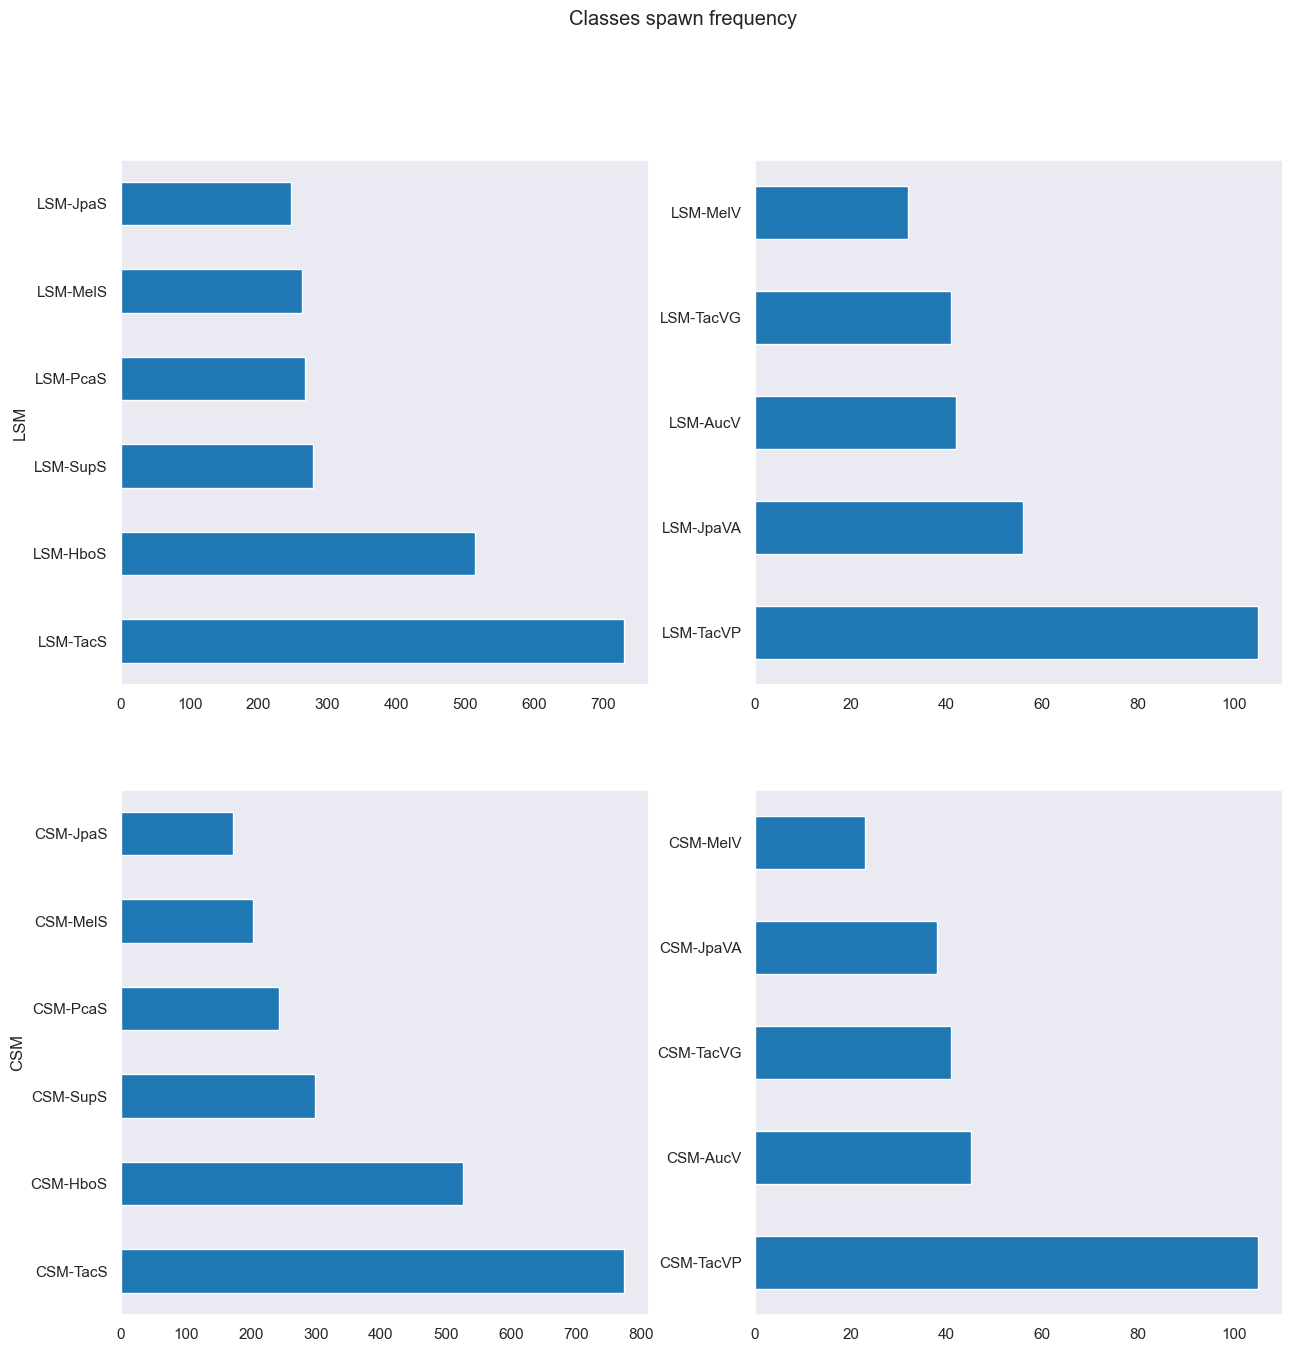

In [36]:
fig, axes = plt.subplots(len(factions), 2, figsize=(15, 15))
fig.suptitle("Classes spawn frequency")
base = class_spawns

for i in range (0, len(factions)):
    # Get faction
    standard = base[base.index.str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard.index.str.contains(classes[j]+"V")]
        veteran = veteran[~veteran.index.str.contains(classes[j]+"S")]
    standard.plot(kind='barh', ax=axes[i,0])
    veteran.plot(kind='barh', ax=axes[i,1])

    # Sort titles and labels
    if (i != 0):
        axes[i,0].set_title("")
        axes[i,1].set_title("")
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")

In [30]:
class_spawns.head()

t-faction-class
CSM-TacS    399
LSM-TacS    366
CSM-HboS    167
LSM-HboS    142
LSM-PcaS    123
Name: count, dtype: int64

In [31]:
# class_spawns.plot.barh(title="Classes spawn frequency")

## Heatmaps

### Damage dealers

In [32]:
x_points = list(damage_df["ic_x"])
y_points = list(damage_df["ic_y"])

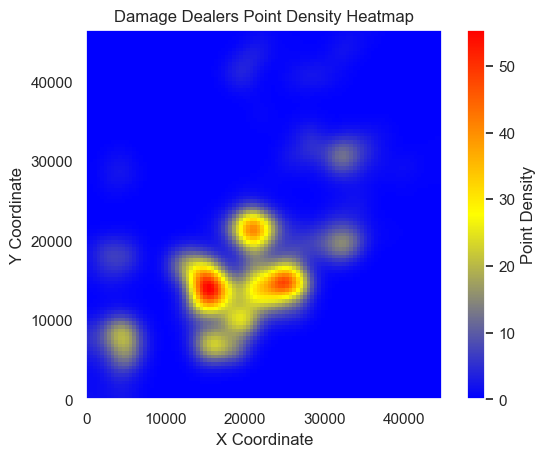

In [36]:
from matplotlib.colors import LinearSegmentedColormap

# Create a 2D histogram to represent point density
heatmap, xedges, yedges = np.histogram2d(x_points, y_points, bins=100)

# Smooth the heatmap using Gaussian convolution
from scipy.ndimage import gaussian_filter

heatmap = gaussian_filter(heatmap, sigma=3)

# Define a custom colormap (blue, yellow, red)
colors = [(0, 'blue'), (0.5, 'yellow'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the heatmap plot
plt.imshow(heatmap.T, origin='lower', extent=[0, xedges.max(), 0, yedges.max()], cmap=custom_cmap)
plt.colorbar(label='Point Density')  # Add a colorbar for reference
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Damage Dealers Point Density Heatmap')

plt.show()

## Prefered Maps and Missions

### Maps

In [37]:
maps = {}
pair = True
for e in old_raw_data["data"]:
    if ("map" in e.keys()):
        if (pair):
            if (e["map"] in maps.keys()):
                maps[e["map"]] = maps[e["map"]] + 1
            else:
                maps[e["map"]] = 1
            pair = False
        else:
            pair = True
maps

{'CycladonComplex': 22,
 'RailgateRavine': 10,
 'Olipsis': 7,
 'ZedekSmall': 3,
 'MaccragesFury': 5}

Text(0.5, 1.0, 'Number of times played (Map)')

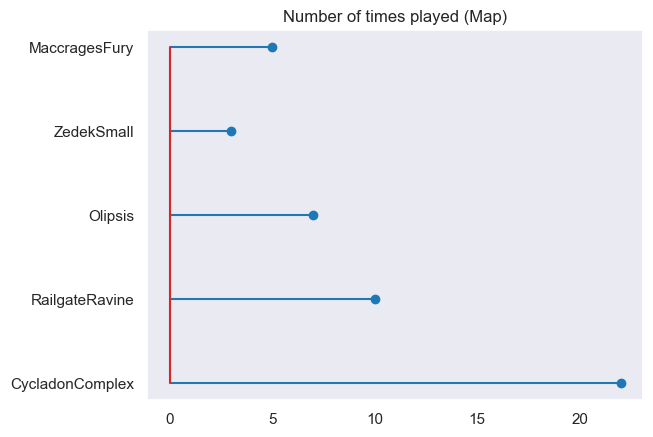

In [38]:
plt.stem(maps.keys(), maps.values(), orientation='horizontal')
plt.title("Number of times played (Map)")

### Missions

In [39]:
missions = {}
pair = True
for e in old_raw_data["data"]:
    if (("mission" in e.keys()) and ("map" in e.keys())):
        if (pair):
            if (e["map"] in missions.keys()):
                if (e["mission"] in missions[e["map"]].keys()):
                    missions[e["map"]][e["mission"]] = missions[e["map"]][e["mission"]] + 1
                else:
                    missions[e["map"]][e["mission"]] = 1
            else:
                missions[e["map"]] = {}
                missions[e["map"]][e["mission"]] = 1
            pair = False
        else:
            pair = True
missions

{'CycladonComplex': {'B_GM_Supremacy_Cycladon_C': 22},
 'RailgateRavine': {'B_GM_HoldTheLine_Railgate_C': 10},
 'Olipsis': {'B_GM_Supremacy_Olipsis_C': 7},
 'ZedekSmall': {'B_GM_MasterDeepStrike_ZedekSmall_C': 3},
 'MaccragesFury': {'B_GM_MasterBoardingAction_MaccragesFury_C': 5}}

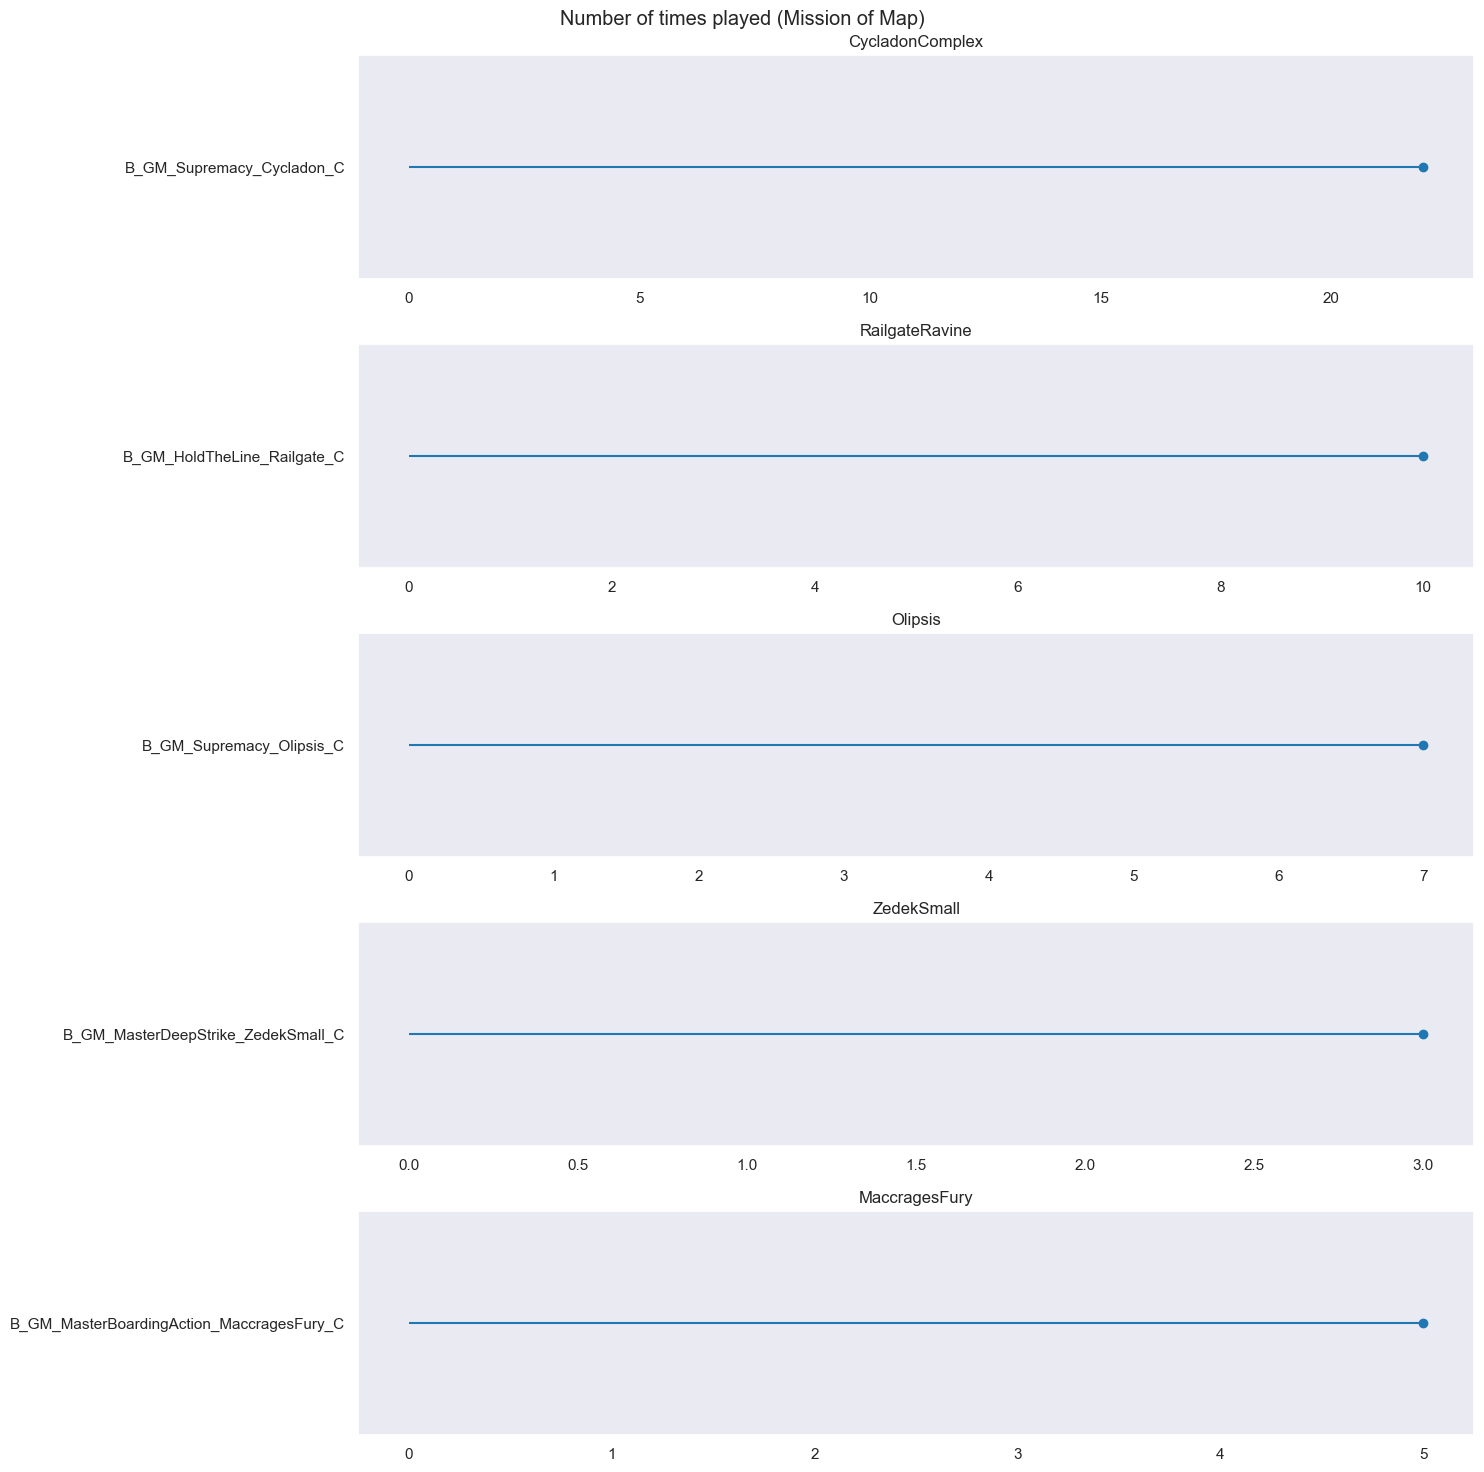

In [41]:
fig, axes = plt.subplots(len(missions), 1, figsize=(15, 15))
fig.suptitle("Number of times played (Mission of Map)")
base = missions

i = 0
for e in (missions.keys()):
    axes[i].stem(missions[e].keys(), missions[e].values(), orientation='horizontal')
    axes[i].set_title(e)
    i = i + 1

fig.tight_layout()